In [8]:
!ffmpeg -i wildtrack_raw/cam5.mp4 -vframes 180 -r 30 -ss 8 wildtrack_raw/images/%06d.png

ffmpeg version 6.1.1-full_build-www.gyan.dev Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.2.0 (Rev10, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --pkg-config=pkgconf --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-liblensfun --e

In [9]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import os
filename = "extr_IDIAP1.xml"

# read the extrinsic and intrinsic calibration files
tree_ext = ET.parse(f'./wildtrack_raw/calibrations/extrinsic/{filename}')
tree_int = ET.parse(f'./wildtrack_raw/calibrations/intrinsic_original/{filename.replace("extr", "intr")}')
root = tree_ext.getroot()
rvec = root.find('rvec').text
tvec = root.find('tvec').text

root = tree_int.getroot()
camera_matrix = root.find('camera_matrix').find('data').text
dist_coeffs = root.find('distortion_coefficients').find('data').text

# convert the strings to numpy arrays
rvec = np.array([float(x) for x in rvec.split()])
tvec = np.array([float(x) for x in tvec.split()])
camera_matrix = np.array([float(x) for x in camera_matrix.split()]).reshape(3, 3)
dist_coeffs = np.array([float(x) for x in dist_coeffs.split()])

# convert the rotation vector to a rotation matrix
rotmat, _ = cv2.Rodrigues(rvec)


# get the list of files in the directory wildtrack_raw/images
files = os.listdir('./wildtrack_raw/images')

for img_name in files:
    # undistort image 
    img = cv2.imread(f"./wildtrack_raw/images/{img_name}")
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 1, (w,h))
    dst = cv2.undistort(img, camera_matrix, dist_coeffs, None, newcameramtx)
    x, y, w, h = roi   
    dst = dst[y:y+h, x:x+w]
    
    dst = dst[:1024, :1024]
    dst = cv2.resize(dst, (512, 512))
    
    # save the undistorted image
    cv2.imwrite(f"./wildtrack_processed/images/{img_name}", dst)


def crop_image(img, x, y, w, h, intrinsics):
    img_ = img[y:y+h, x:x+w]
    intrinsics_ = intrinsics.copy()
    intrinsics_[0, 2] -= x
    intrinsics_[1, 2] -= y
    return img_, intrinsics_

    



In [2]:
print(newcameramtx)

[[1.49855590e+03 0.00000000e+00 9.31032949e+02]
 [0.00000000e+00 1.52407095e+03 4.78573914e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


: 

In [2]:
import json
#open annotations file
with open('./annotations.json') as f:
    annotations = json.load(f)
    
print(annotations)

{'000001.png': [[391, 173], [364, 307], [424, 422], [387, 681]], '000002.png': [[391, 173], [364, 307], [424, 422], [387, 681]], '000003.png': [[391, 173], [364, 307], [424, 422], [387, 681]], '000004.png': [[391, 173], [364, 307], [424, 422], [387, 681], [421, 227]], '000005.png': [[391, 173], [364, 307], [424, 422], [387, 681], [440, 243]], '000006.png': [[391, 173], [364, 307], [424, 422], [387, 681], [440, 242]], '000007.png': [[391, 173], [364, 307], [424, 422], [387, 681], [442, 243]], '000008.png': [[391, 173], [364, 307], [424, 422], [387, 681], [444, 240]], '000009.png': [[391, 173], [364, 307], [424, 422], [387, 681], [448, 244]], '000010.png': [[391, 173], [364, 307], [424, 422], [387, 681], [449, 244]], '000011.png': [[391, 173], [364, 307], [424, 422], [387, 681], [449, 244], [458, 239]], '000012.png': [[391, 173], [364, 307], [424, 422], [387, 681], [449, 244], [458, 239]], '000013.png': [[391, 173], [364, 307], [424, 422], [387, 681], [449, 244], [458, 239]], '000014.png

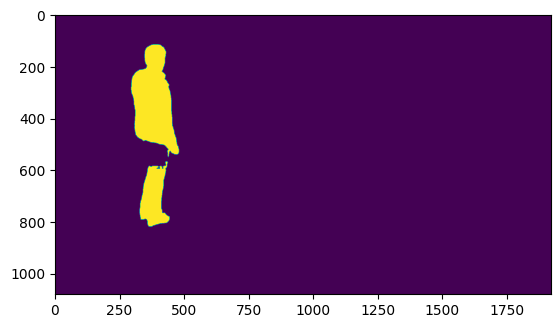

In [3]:
import cv2, numpy as np
import matplotlib.pyplot as plt
str_id = 'wildtrack_processed/masks/000001.png'

image = cv2.imread(str_id)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def remove_small_regions(
    mask: np.ndarray, area_thresh: float, mode: str
) :
    """
    Removes small disconnected regions and holes in a mask. Returns the
    mask and an indicator of if the mask has been modified.
    """
    import cv2  # type: ignore

    assert mode in ["holes", "islands"]
    correct_holes = mode == "holes"
    working_mask = (correct_holes ^ mask).astype(np.uint8)
    n_labels, regions, stats, _ = cv2.connectedComponentsWithStats(working_mask, 8)
    sizes = stats[:, -1][1:]  # Row 0 is background label
    small_regions = [i + 1 for i, s in enumerate(sizes) if s < area_thresh]
    if len(small_regions) == 0:
        return mask, False
    fill_labels = [0] + small_regions
    if not correct_holes:
        fill_labels = [i for i in range(n_labels) if i not in fill_labels]
        # If every region is below threshold, keep largest
        if len(fill_labels) == 0:
            fill_labels = [int(np.argmax(sizes)) + 1]
    mask = np.isin(regions, fill_labels)
    return mask, True
new_mask = remove_small_regions(image[:,:,0], 100, 'islands')

plt.imshow(new_mask[0])


In [11]:
import numpy as np 

a = np.array([[1,2,3],[4,5,6]])

a = a+ np.array([-0.01, 0.01])[:, None]
a[None]-

array([[0.99, 1.99, 2.99],
       [4.01, 5.01, 6.01]])